In [1]:
# Importing Libraries 📚💻
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Flatten, Dense, Dropout, Activation, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications import VGG16

import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
import zipfile

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
from google.colab import files
uploaded = files.upload()  # Select the downloaded zip file

# Extract the dataset
import zipfile
with zipfile.ZipFile(list(uploaded.keys())[0], 'r') as zip_ref:
    zip_ref.extractall('dataset')

Saving archive (9).zip to archive (9).zip


In [3]:
from google.colab import drive
drive.mount('/content/drive')

# Copy dataset to Colab
!cp "/content/dataset.zip" ./

# Extract
!unzip -q dataset.zip -d dataset


Mounted at /content/drive
cp: cannot stat '/content/dataset.zip': No such file or directory
unzip:  cannot find or open dataset.zip, dataset.zip.zip or dataset.zip.ZIP.


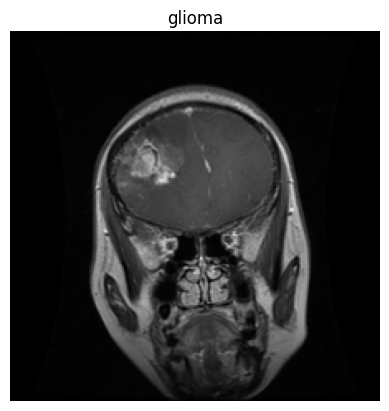

In [4]:
# Set dataset paths
train_datasets = "/content/dataset/Training"
validation_datasets = "/content/dataset/Testing"

# Display a sample image
img_path = '/content/dataset/Training/glioma/Tr-glTr_0000.jpg'
img = Image.open(img_path)
img = img.resize((224, 224))  # Resize to consistent size

# Display image
plt.imshow(img)
plt.title("glioma")
plt.axis('off')  # Hide axis
plt.show()

In [5]:
def prepare_the_datasets(train_datasets, validation_datasets, batch_size, image_size):
    # In the brightness_range, If the random value is less than 1.0, the image becomes darker otherwise brighter.
    train_datasets_generator = ImageDataGenerator(rescale=1.0/255,
                                                brightness_range=(0.8, 1.2))

    validation_datasets_generator = ImageDataGenerator(rescale=1.0/255)

    train_datasets_generator_data = train_datasets_generator.flow_from_directory(
        batch_size=batch_size,
        directory=train_datasets,
        shuffle=True,
        target_size=(image_size, image_size),
        class_mode="categorical"
    )

    validation_datasets_generator_data = validation_datasets_generator.flow_from_directory(
        batch_size=batch_size,
        directory=validation_datasets,
        shuffle=True,
        target_size=(image_size, image_size),
        class_mode="categorical"  # One-Hot-Encoded
    )

    return train_datasets_generator_data, validation_datasets_generator_data

In [ ]:
batch_size = 64
image_size = 224
train_data , validation_data = prepare_the_datasets(train_datasets, validation_datasets, batch_size, image_size)


Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [7]:
# Load pre-trained VGG16 model without the top layers (include_top=False) 🏗️
conv_base = VGG16(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Freeze the pre-trained layers to prevent training (transfer learning without fine-tuning) ❄️
conv_base.trainable = False

# Build a new model on top of the pre-trained base 🧱
model = Sequential()

# Add the pre-trained VGG16 base model
model.add(conv_base)

# Flatten the output for fully connected layers
model.add(Flatten())

# Add a dense layer with ReLU activation
model.add(Dense(256, activation='relu'))

# Add output layer with softmax activation for 4 classes
model.add(Dense(4, activation='softmax'))

# Compile the model with Adam optimizer and categorical crossentropy loss 🛠️
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


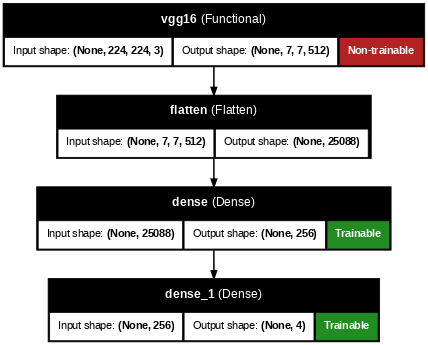

In [8]:
plot_model(
    model,
    to_file='model.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    dpi=55,
    show_trainable=True
)

In [9]:
# Parameters
steps = int(train_data.samples / batch_size)  # Steps per epoch
epochs = 10

# Train the model
history = model.fit(train_data, validation_data = validation_data ,
                    epochs=epochs, steps_per_epoch=steps)

Epoch 1/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 74s 602ms/step - accuracy: 0.6126 - loss: 2.1328 - val_accuracy: 0.8749 - val_loss: 0.3331
Epoch 2/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 7s 74ms/step - accuracy: 0.8750 - loss: 0.3358 - val_accuracy: 0.8619 - val_loss: 0.3447
Epoch 3/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 36s 400ms/step - accuracy: 0.9162 - loss: 0.2359 - val_accuracy: 0.9062 - val_loss: 0.2418
Epoch 4/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 7s 74ms/step - accuracy: 0.8594 - loss: 0.4297 - val_accuracy: 0.9008 - val_loss: 0.2467
Epoch 5/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 34s 377ms/step - accuracy: 0.9395 - loss: 0.1696 - val_accuracy: 0.9230 - val_loss: 0.2198
Epoch 6/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - accuracy: 0.9688 - loss: 0.1105 - val_accuracy: 0.9199 - val_loss: 0.2255
Epoch 7/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 35s 386ms/step - accuracy: 0.9660 - loss: 0.1083 - val_accuracy: 0.9436 - val_loss: 0.1461
Epoch 8/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 7s 74ms/step - accuracy: 0.9844 - loss: 0.0891 - val_accuracy: 0.


Training model without fine-tuning...


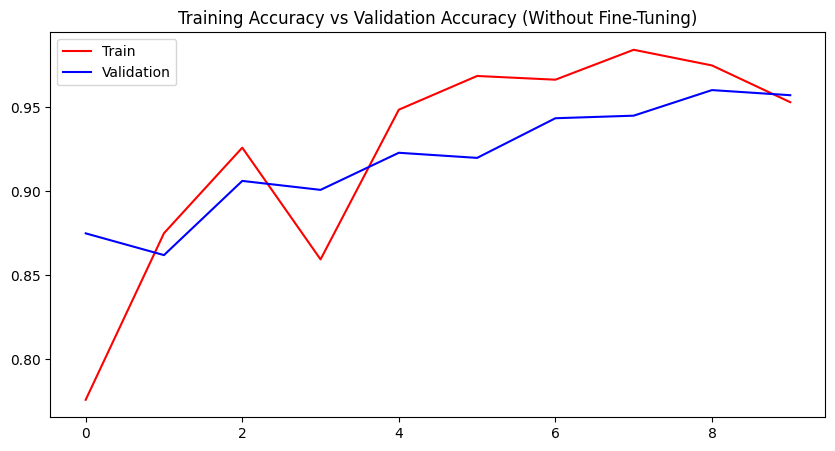

In [10]:
# Train the model
print("\nTraining model without fine-tuning...")
# Plotting the graph of Accuracy and Validation Accuracy
plt.figure(figsize=(10, 5))
plt.title('Training Accuracy vs Validation Accuracy (Without Fine-Tuning)')
plt.plot(history.history['accuracy'], color='red', label='Train')
plt.plot(history.history['val_accuracy'], color='blue', label='Validation')
plt.legend()
plt.show()


In [11]:
print("\nTransfer Learning With Fine-Tuning 🔄🧠")
# Load VGG16 model
base_model = VGG16(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Freeze layers of base model
for layer in base_model.layers:
    layer.trainable = False

# Optionally unfreeze layers of a specific block (fine-tuning)
for layer in base_model.layers:
    if layer.name.startswith('block5'):
        layer.trainable = True

# Build the model
inputs = Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)  # Base model in inference mode
x = Flatten()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(4, activation='softmax')(x)

model1 = Model(inputs, outputs)

# Compile model
model1.compile(optimizer=Adam(learning_rate=0.0001),  # While Finetuning value of learning rate should be small
              loss='categorical_crossentropy',
              metrics=['accuracy'])



Transfer Learning With Fine-Tuning 🔄🧠


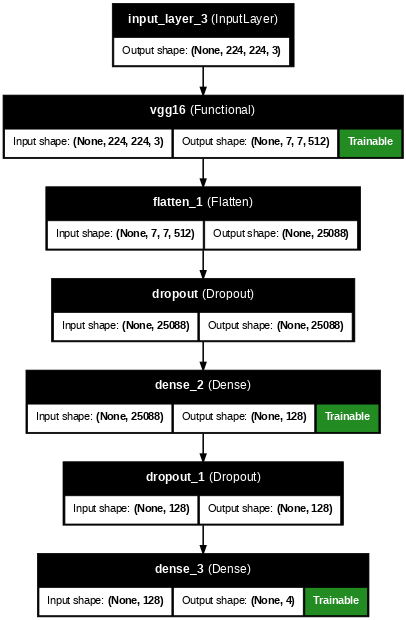

In [12]:
# Plot model architecture
plot_model(
    model1,
    to_file='model1.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    dpi=55,
    show_layer_activations=False,
    show_trainable=True
)


Training model with fine-tuning...
Epoch 1/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 58s 544ms/step - accuracy: 0.7400 - loss: 0.6818 - val_accuracy: 0.8780 - val_loss: 0.3210
Epoch 2/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - accuracy: 0.8438 - loss: 0.4931 - val_accuracy: 0.9069 - val_loss: 0.2589
Epoch 3/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 59s 438ms/step - accuracy: 0.9264 - loss: 0.2038 - val_accuracy: 0.9077 - val_loss: 0.2429
Epoch 4/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 7s 78ms/step - accuracy: 0.9375 - loss: 0.1942 - val_accuracy: 0.9108 - val_loss: 0.2454
Epoch 5/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 75s 447ms/step - accuracy: 0.9557 - loss: 0.1253 - val_accuracy: 0.9550 - val_loss: 0.1176
Epoch 6/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 7s 76ms/step - accuracy: 0.9219 - loss: 0.1253 - val_accuracy: 0.9596 - val_loss: 0.1052
Epoch 7/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 38s 427ms/step - accuracy: 0.9728 - loss: 0.0710 - val_accuracy: 0.9603 - val_loss: 0.0970
Epoch 8/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - accuracy: 0.98

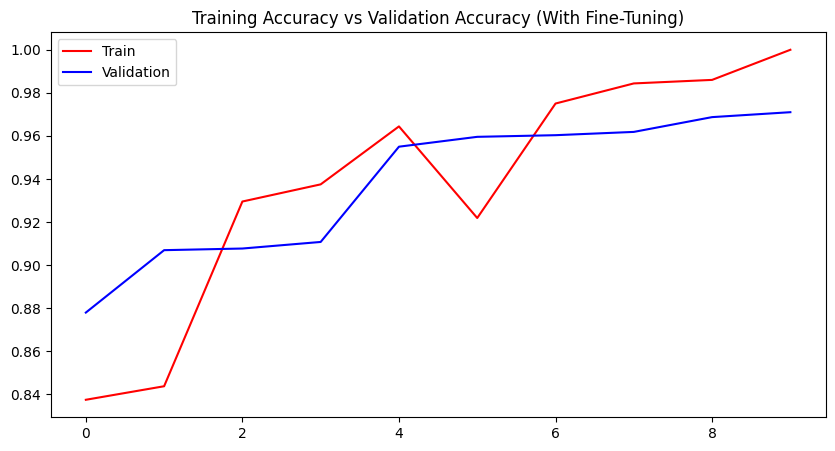

In [13]:
# Parameters
steps = int(train_data.samples / batch_size)  # Steps per epoch
epochs = 10

# Train the model
print("\nTraining model with fine-tuning...")
history1 = model1.fit(train_data, validation_data=validation_data,
                     epochs=epochs, steps_per_epoch=steps)

# Plotting the graph of Accuracy and Validation Accuracy
plt.figure(figsize=(10, 5))
plt.title('Training Accuracy vs Validation Accuracy (With Fine-Tuning)')
plt.plot(history1.history['accuracy'], color='red', label='Train')
plt.plot(history1.history['val_accuracy'], color='blue', label='Validation')
plt.legend()
plt.show()

In [14]:
# Saving The models 💾📥
model.save('model.h5')
model1.save('model1.h5')

# Print final accuracies
final_acc_no_finetune = history.history['val_accuracy'][-1] * 100
final_acc_with_finetune = history1.history['val_accuracy'][-1] * 100

print("\nFinal Results:")
print(f"VGG16 Without Fine-Tuning = Validation Accuracy: {final_acc_no_finetune:.2f}%")
print(f"VGG16 With Fine-Tuning = Validation Accuracy: {final_acc_with_finetune:.2f}%")


Final Results:
VGG16 Without Fine-Tuning = Validation Accuracy: 95.73%
VGG16 With Fine-Tuning = Validation Accuracy: 97.10%


In [25]:
# First, let's check the actual class indices from our training data generator
train_data.class_indices

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

In [26]:
# Load the saved models
from tensorflow.keras.models import load_model
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from google.colab import files
from PIL import Image

# Load both models (you can choose which one to use)
model_no_ft = load_model('model.h5')
model_with_ft = load_model('model1.h5')

# CORRECTED CLASS NAMES ORDER
class_names = ['glioma', 'meningioma', 'no tumor', 'pituitary']  # Changed order

def predict_image(img_path, model=model_with_ft):
    # Load and preprocess image
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize

    # Make prediction
    prediction = model.predict(img_array)
    predicted_class = class_names[np.argmax(prediction)]  # Now uses correct order
    confidence = np.max(prediction) * 100

    # Display results
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_class}\nConfidence: {confidence:.2f}%")
    plt.axis('off')
    plt.show()

    return predicted_class, confidence


Testing with sample images from dataset:

Analyzing: /content/dataset/Testing/glioma/Te-gl_0010.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step


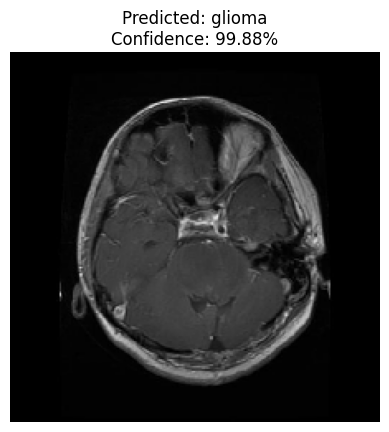


Analyzing: /content/dataset/Testing/meningioma/Te-me_0010.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


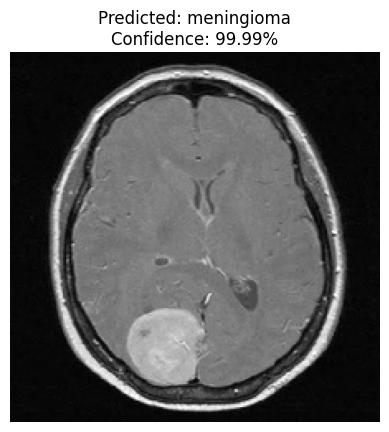


Analyzing: /content/dataset/Testing/pituitary/Te-pi_0010.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


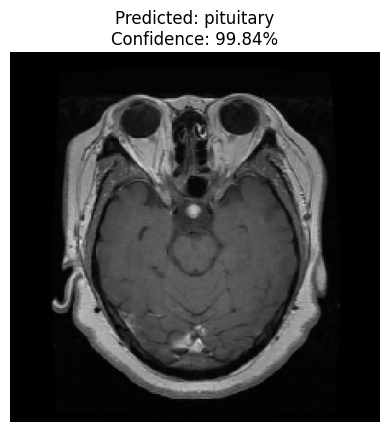


Analyzing: /content/dataset/Testing/notumor/Te-no_0010.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


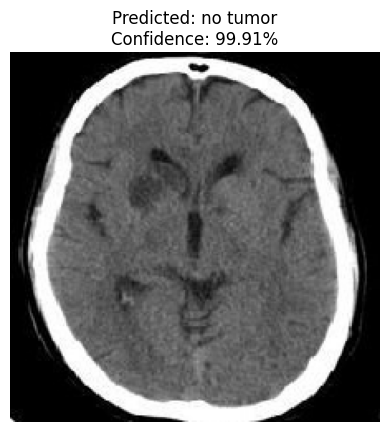

In [27]:
# Test with sample images from the dataset
test_images = [
    '/content/dataset/Testing/glioma/Te-gl_0010.jpg',
    '/content/dataset/Testing/meningioma/Te-me_0010.jpg',
    '/content/dataset/Testing/pituitary/Te-pi_0010.jpg',
    '/content/dataset/Testing/notumor/Te-no_0010.jpg'
]

print("\nTesting with sample images from dataset:")
for img_path in test_images:
    print(f"\nAnalyzing: {img_path}")
    predict_image(img_path)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Saving Te-pi_0293.jpg to Te-pi_0293.jpg

Analyzing: Te-pi_0293.jpg

Without Fine-Tuning:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


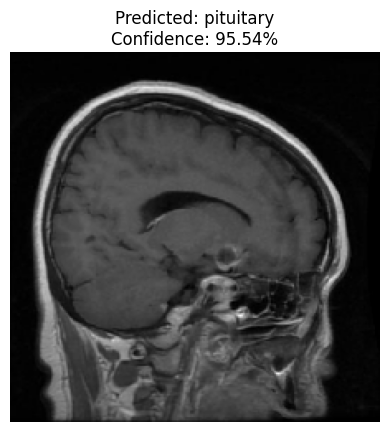


With Fine-Tuning:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


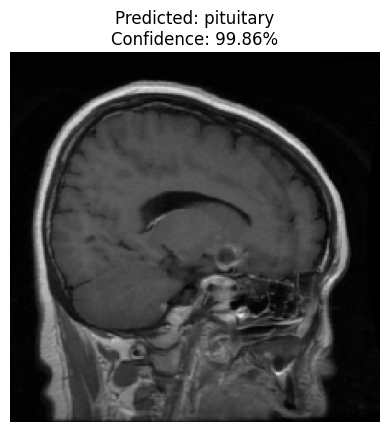

In [36]:
def upload_and_predict():
    # Upload image
    uploaded = files.upload()
    for filename in uploaded.keys():
        print(f"\nAnalyzing: {filename}")
        # print("\nWithout Fine-Tuning:")
        # pred1, conf1 = predict_image(filename, model_no_ft)
        print("\nWith Fine-Tuning:")
        pred2, conf2 = predict_image(filename, model_with_ft)

# Run this to upload your own MRI image
upload_and_predict()

